In [1]:
import yfinance as yf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.optimize as sco
from tqdm.notebook import tqdm

plt.style.use('bmh')

In [2]:
tickers = ['AAPL', 'INTC', 'IBM', 'MSFT']
data = yf.download(tickers, period='5y', interval='1d', auto_adjust=True)
data.Close

[*********************100%***********************]  4 of 4 completed


,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-27,32.320957,135.802704,32.122070,59.957726
2017-02-28,32.335110,136.120636,31.849323,59.724365
2017-03-01,32.996025,137.733017,31.611782,60.620502
2017-03-02,32.800114,136.658127,31.594179,59.752365
2017-03-03,32.993668,136.294769,31.585377,59.976391
...,...,...,...,...
2022-02-18,167.300003,124.349998,45.040001,287.929993
2022-02-22,164.320007,123.919998,44.689999,287.720001
2022-02-23,160.070007,122.070000,44.650002,280.269989


In [3]:
returns = np.log(data.Close/data.Close.shift(1)).dropna()
returns

,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-28,0.000438,0.002338,-0.008527,-0.003900
2017-03-01,0.020233,0.011776,-0.007486,0.014893
2017-03-02,-0.005955,-0.007835,-0.000557,-0.014424
2017-03-03,0.005884,-0.002662,-0.000279,0.003742
2017-03-06,-0.003153,0.002330,-0.009235,0.000311
...,...,...,...,...
2022-02-18,-0.009400,-0.004974,-0.054651,-0.009678
2022-02-22,-0.017973,-0.003464,-0.007801,-0.000730
2022-02-23,-0.026205,-0.015042,-0.000895,-0.026234


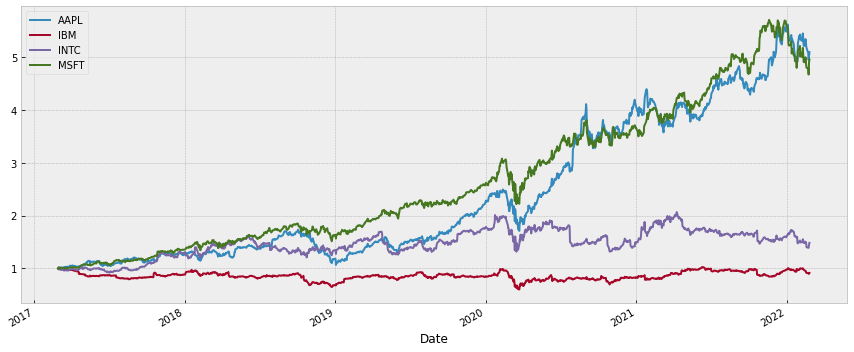

In [4]:
returns.cumsum().apply(np.exp).plot(figsize=(12,5))
plt.tight_layout()
plt.show()

In [5]:
avg_returns = returns.mean() * 252
cov_mat = returns.cov() * 252

In [6]:
def get_portfolio_return(w, avg_returns):
    return np.sum(avg_returns * w)

def get_portfolio_volatility(w, avg_returns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [7]:
def get_efficient_frontier(avg_returns, cov_mat, returns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for _ in range(n_assets))
    initial_guess = n_assets * [1/n_assets]
    for ret in tqdm(returns_range, leave=False):
        constraints = ({'type':'eq', # portfolio return == ret --> portfolio return - ret == 0
                        'fun':lambda x: get_portfolio_return(x, avg_returns) - ret},
                       
                       {'type':'eq', # sum weights == 1 --> sum weights - 1 == 0
                        'fun':lambda x: np.sum(x) - 1})
        
        # minimize volatility for given return
        efficient_portfolio = sco.minimize(get_portfolio_volatility,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [8]:
# need to manually define returns range
returns_range = np.linspace(-0.019, 0.3, 1000) 
efficient_portfolios = get_efficient_frontier(avg_returns, cov_mat, returns_range)
volatility_range = np.array([ef['fun'] for ef in efficient_portfolios])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
sharpe_ratios = returns_range / volatility_range
min_idx = np.argmin(volatility_range)
sharpe_idx = np.argmax(sharpe_ratios)

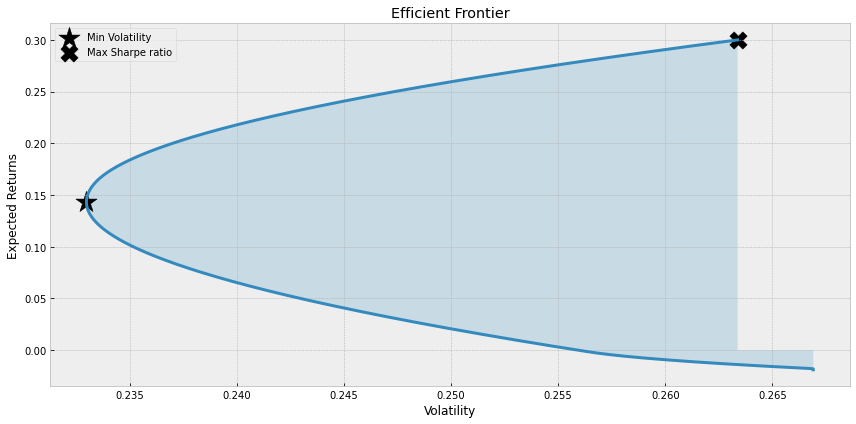

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(volatility_range, returns_range, linewidth=3)
ax.fill_between(volatility_range, returns_range, alpha=0.2)
ax.scatter(volatility_range[min_idx], returns_range[min_idx], 
           marker='*', s=500, c='k', label='Min Volatility')
ax.scatter(volatility_range[sharpe_idx], returns_range[sharpe_idx],
           marker='X', s=300, c='k', label='Max Sharpe ratio')
ax.set_title('Efficient Frontier')
ax.set_xlabel('Volatility')
ax.set_ylabel('Expected Returns')
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
print("***** Minimum Volatility Portfolio *****")
print("Weights")
for t, w in zip(tickers, efficient_portfolios[min_idx]['x']):
    print(f"{t}:{w*100:.2f}%", end='  ')
print("\nPerformance")
print(f"Returns:{returns_range[min_idx]*100:.2f}%", end='  ')
print(f"Volatility:{volatility_range[min_idx]*100:.2f}%", end='  ')
print(f"Sharpe ratio:{sharpe_ratios[min_idx]*100:.2f}%")

print('\n')
print("***** Maximum Sharpe ratio Portfolio *****")
print("Weights")
for t, w in zip(tickers, efficient_portfolios[sharpe_idx]['x']):
    print(f"{t}:{w*100:.2f}%", end='  ')
print("\nPerformance")
print(f"Returns:{returns_range[sharpe_idx]*100:.2f}%", end='  ')
print(f"Volatility:{volatility_range[sharpe_idx]*100:.2f}%", end='  ')
print(f"Sharpe ratio:{sharpe_ratios[sharpe_idx]*100:.2f}%")

***** Minimum Volatility Portfolio *****
Weights
AAPL:16.02%  INTC:51.30%  IBM:1.89%  MSFT:30.78%  
Performance
Returns:14.32%  Volatility:23.30%  Sharpe ratio:61.47%


***** Maximum Sharpe ratio Portfolio *****
Weights
AAPL:31.24%  INTC:6.57%  IBM:0.00%  MSFT:62.18%  
Performance
Returns:30.00%  Volatility:26.34%  Sharpe ratio:113.90%
